This notebook applies a random forest classifier to classify Alzheimer's disease from anatomical MRI images using a low-dimensional feature space. Key steps include data formatting and quality checks, feature extraction and visualization, and permutation testing for statistical significance using parallel processing. It also explores feature importance and interpretation.

In [0]:
# "standard"
import numpy as np
import pandas as pd

# machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from scipy.stats import false_discovery_control
import mlflow
mlflow.autolog(disable=True)

# Parallel computing
import dask
from dask.distributed import Client, progress

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# misc
import cv2, pickle, os , time, magic
from IPython.display import clear_output

import sys
sys.path.append('/Workspace/Users/bjedelma@gmail.com/Alzheimers-MRI-Classification/src')
from random_forest_permute import classification_RF_shuffle, iteration_permute, iteration_PCs, iteration_permute_PCs
from data_io import save_model_s3, load_model_s3, save_pickle_s3, load_pickle_s3

clear_output(wait=False)

Mount AWS S3 bucket containing processed data

In [0]:
ACCESS_KEY = dbutils.secrets.get(scope="brad-aws", key="access_key")
SECRET_KEY= dbutils.secrets.get(scope="brad-aws", key="secret_key")

# specify bucket and mount point
AWS_S3_BUCKET = "databricks-workspace-stack-brad-personal-bucket/AD_MRI_classification/raw/"
MOUNT_NAME = f"/mnt/{AWS_S3_BUCKET.split('/')[-2]}"
SOURCE_URL = f"s3a://{AWS_S3_BUCKET}"
EXTRA_CONFIGS = { "fs.s3a.access.key": ACCESS_KEY, "fs.s3a.secret.key": SECRET_KEY}

# mount bucket
if any(mount.mountPoint == MOUNT_NAME for mount in dbutils.fs.mounts()):
    print(f"{MOUNT_NAME} is already mounted.")
else:
    dbutils.fs.mount(SOURCE_URL, MOUNT_NAME, extra_configs = EXTRA_CONFIGS)
    print(f"{MOUNT_NAME} is now mounted.")

/mnt/raw is already mounted.


In [0]:
# Load data file and unpack contents
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_name='AD_MRI_classification/preprocessed/data_preprocessed.pkl'
data=load_pickle_s3(bucket_name, s3_file_name, dbutils)

train_data=data['train_data']
train_lab=data['train_labels']
test_data=data['test_data']
test_lab=data['test_labels']
Lab = ['Mild', 'Moderate', 'None', 'Very Mild']
    
# Convert labels to categorical
train_lab_cat = to_categorical(train_lab.astype('int8'), num_classes=4)
test_lab_cat = to_categorical(test_lab.astype('int8'), num_classes=4)

Decompose data with PCA

In [0]:
train_data_pca = []
for i in range(len(train_data)):
    train_data_pca.append(np.reshape(train_data[i], (1, -1)))    
train_data_pca = np.vstack(train_data_pca[:])

# decompose with PCA and look at various metrics/info
num_comp = 50
pca = PCA(n_components = num_comp)
pca.fit(train_data_pca)
clear_output(wait=False)

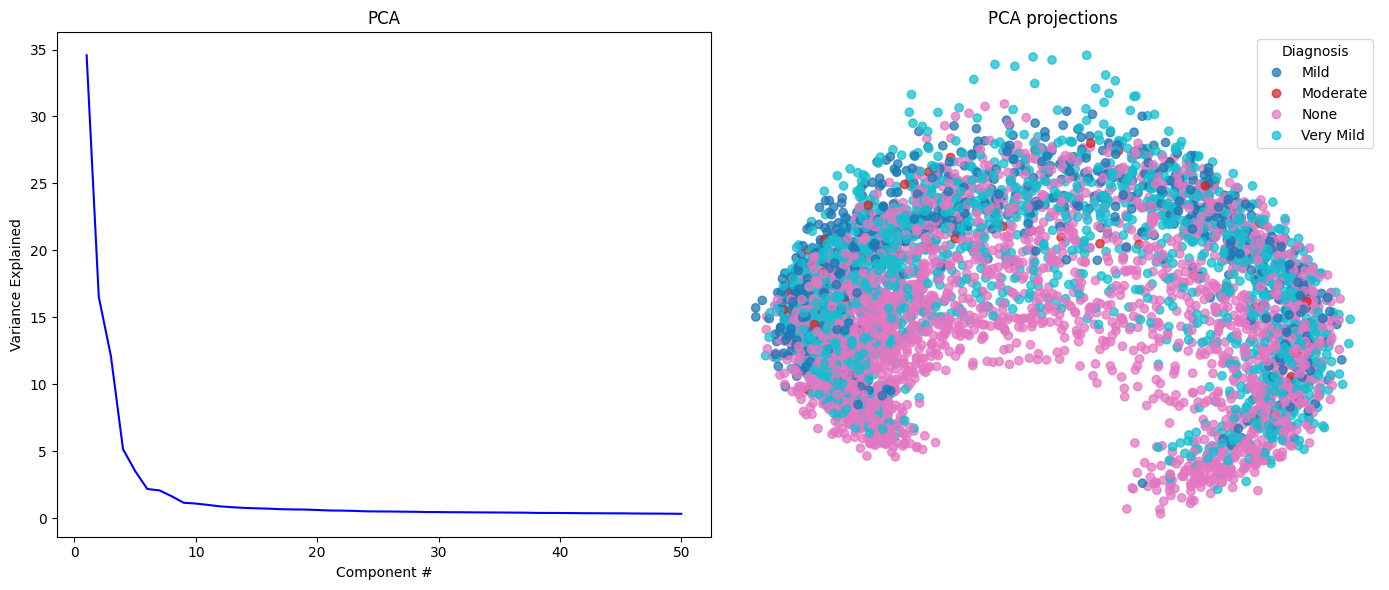

In [0]:
# project data on first two PC's
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
load_train = np.matmul(train_data_pca, loadings[:,:2])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot variance explained
ax1.plot(np.linspace(1, num_comp, num_comp), pca.explained_variance_[:num_comp] / sum(pca.explained_variance_[:num_comp]) * 100, 'b')
ax1.set_title('PCA')
ax1.set_xlabel('Component #')
ax1.set_ylabel('Variance Explained')

# Plot first two PCs
s = ax2.scatter(load_train[:, 0], load_train[:, 1], c=train_lab * 2, cmap='tab10', alpha=0.75)
handles, labels = s.legend_elements()
legend = ax2.legend(handles=handles, labels=Lab, title='Diagnosis', loc='upper right')
ax2.axis('off')
ax2.set_title('PCA projections')
ax2.set_xlabel('PC 1')
ax2.set_ylabel('PC 2')

plt.tight_layout()
plt.show()

Apply random forest classifier to first two PCs

In [0]:
# Train random forest classifier on first two PCs and apply to test data
rf = RandomForestClassifier()

# Train classifier
load_train = np.matmul(train_data_pca, loadings[:,:2])
rf.fit(load_train, train_lab)

# Properly format test data and extract same features (PC loadings)
test_data_pca = []
for i in range(len(test_data)):
    test_data_pca.append(np.reshape(test_data[i], (1, -1)))    
test_data_pca = np.vstack(test_data_pca[:])

# Test data in PC space
load_test = np.matmul(test_data_pca, loadings[:,:2])

# Predict unseen testdata
predictions = rf.predict(load_test)
clear_output(wait=False)

Overall classification accuracy is: 47.8125 %
Data uploaded to S3 bucket: databricks-workspace-stack-brad-personal-bucket/AD_MRI_classification/results/RF_2PC_acc.pkl


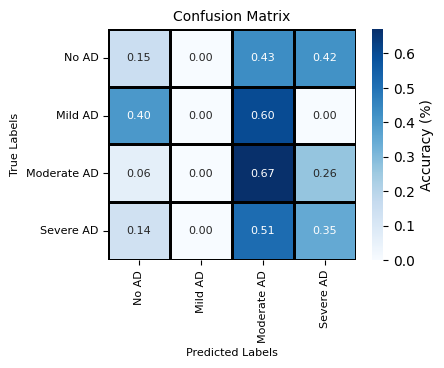

In [0]:
# compare predictions with test labels and compute accuracy
result = predictions - test_lab
result_binary = np.argwhere(result == 0)
correct = np.size(result_binary,0)
acc = correct/test_lab.shape[0]*100
print(f"Overall classification accuracy is: {acc} %")

# Generate and plot confusion matrix
conf_matrix = confusion_matrix(test_lab, predictions)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(4, 3))

sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', cbar_kws={'label': 'Accuracy (%)'}, 
            xticklabels=['No AD', 'Mild AD', 'Moderate AD', 'Severe AD'], 
            yticklabels=['No AD', 'Mild AD', 'Moderate AD', 'Severe AD'], 
            ax=ax, linewidths=1, linecolor='black', annot_kws={"size": 8})
ax.set_xlabel('Predicted Labels', fontsize=8)
ax.set_ylabel('True Labels', fontsize=8)
ax.set_title('Confusion Matrix', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=8)

# Save results
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/RF_2PC_acc.pkl'
save_pickle_s3(acc, bucket_name, s3_file_path, dbutils)

When using the top two PCs, we see a modest classification rate on the test set. However, there is a clear bias here towards the Moderate AD class, which had the largest bias in the training dataset.

Furthermore, using two PC's  is arbitrary and is easy simply due to visualization purposes. We can also examine accuracy as a function of the number of PCs, and visualize the PC loading maps to interpret the classification results. But first, let's run some statistics to determine if the classification is significant in its current state.

We perform statistical testing to determine if the classification is significantly different (above) chance level. Here, we will do this using permutation testing where we randomly shuffle the training labels before building the classifier and then obtain accuracy values with the original testing labels. By randomly shuffling the training labels hundreds of times, we can build a null distribution and then observe where the "true" classification rate falls.

Since we will be doing a lot of iterations, let's first validate that parallel processing reducs computation time compared to serial processing

In [0]:
train_lab_shuffle= train_lab
load_train=np.matmul(train_data_pca, loadings[:,:2])

# Serial for loop
start_time = time.time()

acc_shuffle_nodask = []
for i in range(100):
    acc_tmp = classification_RF_shuffle(
        load_train,
        train_lab_shuffle,
        load_test,
        test_lab)
    
    acc_shuffle_nodask.append(acc_tmp)

end_time = time.time()
total_time = end_time - start_time


# Parallel for loop (dask)
start_time1 = time.time()

acc_shuffle_dask = iteration_permute(
    load_train,
    train_lab_shuffle,
    load_test,
    test_lab,
    n_iterations=100)
    
clear_output(wait = True)

end_time1 = time.time()
total_time1 = end_time1 - start_time1

clear_output(wait=False)
print(f"Serial For Loop: {total_time} seconds")
print(f"Parallel For Loop: {total_time1} seconds")

Serial For Loop: 557.9061996936798 seconds
Parallel For Loop: 442.1654887199402 seconds


We can see that parallelization with dask markedly reduces the computation time (CPU) by ~20%.

Total time elapsed: 1746.0532851219177 seconds
Data uploaded to S3 bucket: databricks-workspace-stack-brad-personal-bucket/AD_MRI_classification/results/RF_2PC_acc_permute.pkl


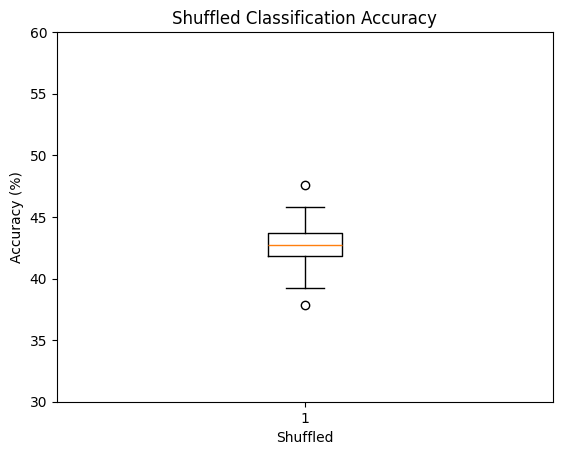

In [0]:
# Permute 500 times
start_time = time.time()
acc_permute = []
for i in range(10):
    acc_tmp=iteration_permute(
        load_train,
        train_lab_shuffle,
        load_test,
        test_lab,
        n_iterations=50)
    
    acc_permute = np.concatenate((acc_permute, acc_tmp), axis=0)

b = plt.boxplot(acc_permute)
plt.title('Shuffled Classification Accuracy')
plt.xlabel('Shuffled')
plt.ylabel('Accuracy (%)')
plt.ylim(30, 60)

end_time = time.time()
total_time = end_time - start_time
print(f"Total time elapsed: {total_time} seconds")

# Save results
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/RF_2PC_acc_permute.pkl'
save_pickle_s3(acc_permute, bucket_name, s3_file_path, dbutils)

Determine significance of classification accuracy (permutation test)

In [0]:
# Load results
bucket_name="databricks-workspace-stack-brad-personal-bucket"

s3_file_path='AD_MRI_classification/results/RF_2PC_acc.pkl'
acc=load_pickle_s3(bucket_name, s3_file_path, dbutils)

s3_file_path='AD_MRI_classification/results/RF_2PC_acc_permute.pkl'
acc_permute=load_pickle_s3(bucket_name, s3_file_path, dbutils)

# Permutation p-value derivation
null_above_value = (acc_permute > acc).sum()
p_value = null_above_value/np.size(acc_permute,0)
display(f"The p-value for the classification accuracy of {acc:.2f}% is {p_value}")

'The p-value for the classification accuracy of 48.12% is 0.0'

Now explore RF classification as a function of PCs

In [0]:

num_pc=np.linspace(1,50,50, dtype = 'int')
acc_pc=iteration_PCs(
    train_data_pca,
    train_lab,
    test_data_pca,
    test_lab,
    loadings,
    num_pc)
clear_output(wait=False)

# Save results
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/RF_NUM_PCS_acc.pkl'
save_pickle_s3(acc_pc, bucket_name, s3_file_path, dbutils)

Data uploaded to S3 bucket: databricks-workspace-stack-brad-personal-bucket/AD_MRI_classification/results/RF_NUM_PCS_acc.pkl


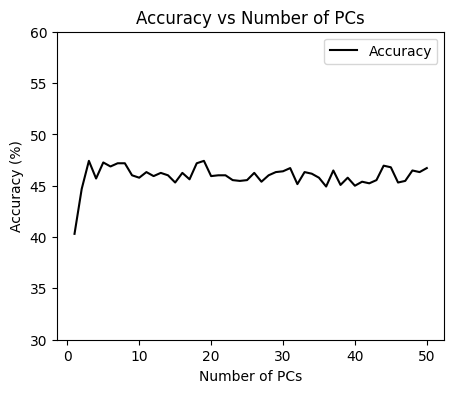

In [0]:
# Load results
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/RF_NUM_PCS_acc.pkl'
acc_pc=load_pickle_s3(bucket_name, s3_file_path, dbutils)

# Plot accuracy as a function of number of PCs
plt.figure(figsize=(5, 4))
plt.plot(num_pc, acc_pc, 'k', label='Accuracy')
plt.xlabel('Number of PCs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Number of PCs')
plt.ylim(30, 60)
plt.show()

## Permutation testing for each number of PCs

In [0]:
# Permute 500 times per PC step
start_time = time.time()

train_lab_shuffle = train_lab
num_pc_values = np.linspace(2, 50, 25, dtype='int')

acc_pc_permute_tot = []
for num_pc in num_pc_values:  # pc
    acc_pc_permute = np.array([])

    for i in range(2):  # iteration within pc
        acc_tmp = iteration_permute_PCs(
            train_data_pca,
            train_lab_shuffle,
            test_data_pca,
            test_lab,
            loadings,
            num_pc,
            n_iterations=10
        )
        acc_pc_permute = np.concatenate((acc_pc_permute, acc_tmp), axis=0)

    acc_pc_permute_tot.append(acc_pc_permute)

acc_pc_permute_tot = np.vstack(acc_pc_permute_tot)

end_time = time.time()
total_time = end_time - start_time
print(f"Total time: {total_time:.2f} seconds")

# Save results
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/RF_NUM_PCS_acc_permute.pkl'
save_pickle_s3(acc_pc_permute_tot, bucket_name, s3_file_path, dbutils)

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-4855710378099013>, line 2
      1 # Permute 500 times per PC step
----> 2 start_time = time.time()
      4 train_lab_shuffle = train_lab
      5 num_pc_values = np.linspace(2, 50, 25, dtype='int')

NameError: name 'time' is not defined

Compare classification accuracy to chance level for each PC step

In [0]:
# plot accuracy as a function of PCs

# accuracy as a function of PCs
plt.plot(np.linspace(1,np.size(acc_PC_compile,0), np.size(acc_PC_compile,0)), acc_PC_compile, 'k')

# corresponding chance level
p_value_compile = []
for i in range(len(acc_shuffle_PC_compile)):
    b = plt.boxplot(acc_shuffle_PC_compile[i], 'b', positions = [i+1], flierprops = {'marker': '.', 'markersize': 5})

    # permutation testing
    null_above_value = (acc_shuffle_PC_compile[i] > acc_PC_compile[i]).sum()
    p_value_compile.append(null_above_value/np.size(acc_shuffle_PC_compile[i],0))

# visualize statistical results
p_value_compile = np.array([float(num) for num in p_value_compile])
p_value_adj = false_discovery_control(p_value_compile)   

for i in range(len(p_value_adj)): 
    if p_value_adj[i] < 0.05:
        plt.scatter(i, 95, s = 10, c = 'r', marker = "*")

plt.title('Classification accuracy')
plt.xlabel('# of PCs included')
plt.ylabel('Accuracy (%)')
plt.ylim(30, 100)
plt.xlim(-5, 105)
p_value_compile

## Feature interpretation

### Visualize spatial PC maps to identify features that contribute to data variance and classification

In [0]:
f, ax = plt.subplots(5,4)
lim = 20
for ipc in range(lim):

    PC_map = loadings[:,ipc]
    PC_map = np.reshape(PC_map, (128,128))
    clim = max(abs(np.min(PC_map)), abs(np.max(PC_map)))

    idx1 = np.floor(ipc/4).astype(int)
    idx2 = np.fmod(ipc,4)
    ax[idx1, idx2].axis('off')
    ax[idx1, idx2].imshow(PC_map, cmap = "magma", vmin = -clim, vmax = clim)
    ax[idx1, idx2].set_title(f'PC# {ipc +1}', fontsize = 10)
    plt.tight_layout()

#### Here we can see that for each of the top 20 PC's there are brain regions are more strongly weighted than others (in either the positive or negative direction). It is important to note that it does not appear that each image used in this dataset came from the same location/slice within the brain. We do not know if certain slices are over- or under-represented in different AD classes and therefore cannot say with certainty whether specific anatomical structures drive different stages of AD. Nevertheless,